# EPFL Machine Learning Higgs

## Loading and preprocessing

In [41]:
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
from helpers import load_data, one_hot_encode, standardize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
data_directory = '../data'
train_dataset_path = os.path.join(data_directory, 'train.csv')
public_test_dataset_path = os.path.join(data_directory, 'test.csv')

# Loading the data
_, Y_train_public, feature_names, X_train_public = load_data(train_dataset_path)
ids_test_public, _, _, X_test_public = load_data(public_test_dataset_path)

In [67]:
# We need to deal with -999 somehow (missing values)
# For now just assume a naive approach and set the values to 0
# Since they are floats, we add an epsilon against numerical errors
EPSILON = 1E-4
mask_train = np.abs(X_train_public + 999) <= EPSILON
mask_test = np.abs(X_test_public + 999) <= EPSILON
print('Proportion of missing values:', np.sum(mask_train)/(mask_train.shape[0]*mask_train.shape[1]))
print('Proportion of missing values:', np.sum(mask_test)/(mask_test.shape[0]*mask_test.shape[1]))

X_train_public[mask_train] = 0
X_test_public[mask_test] = 0

Proportion of missing values: 0.0
Proportion of missing values: 0.0


In [68]:
# We will standardize the data based on the mean and standard deviation of the !!! public train dataset !!! (is this okay? We are basically estimating the population mean and std tis way)
# We can also try normalizing between 0-1, since some values stay quite large
# ! The method standardizes in-place !
# The values are still quite high... Maybe different pre-processing?
continuous_column_idxs = np.where(feature_names != "PRI_jet_num")[0]
column_means, column_stds = standardize(X_train_public, continuous_column_idxs)
_, _ = standardize(X_test_public, continuous_column_idxs, column_means, column_stds)

In [4]:
# We will need to add interaction terms to deal with co-linearity somewhere (like x1*x2 instead of just x1 and x2)


In [69]:
# Note to self: Make sure to standardize before one-hot encoding, otherwise specifying the columns could be annoying

# Then we will need to notice the discrete-valued column, since this needs to be one-hot encoded
# In our dataset, only "PRI_jet_num" is discrete.
discrete_column_idxs = np.where(feature_names == "PRI_jet_num")[0]

# Update the features by one-hot encoding the discrete ones, but only update the feature names at the end
# They will be the same for the train and test set anyway
X_train_public, _ = one_hot_encode(X_train_public, discrete_column_idxs, feature_names)
X_test_public, feature_names = one_hot_encode(X_test_public, discrete_column_idxs, feature_names)

In [70]:
# Since this is a binary classification problem, we do not need to one-hot encode the y-vector, but we can just use binary values
positive_sample = 'b'
negative_sample = 's'
Y_train_public = np.expand_dims((Y_train_public == positive_sample).astype(np.int32), axis=1)

# ! There are quite some more positive than negative samples, maybe we could try to weigh negative samples more or something? !
print('Number of positive samples:', np.sum(Y_train_public))
print('Number of negative samples:', len(Y_train_public) - np.sum(Y_train_public))

Number of positive samples: 164333
Number of negative samples: 85667


# Training and analysis

After preprocessing, the new features of the public train- and test dataset are stored in "X_train_public" and "X_test_public". The labels are binary values stored in "Y_train_public". Furthermore, the feature column names are found in "feature_names"

In [71]:
# We will do k-fold cross validation to create subsets of the training and testing datasets
print(feature_names)
print(X_train_public.shape, X_test_public.shape)
print(Y_train_public.shape)

['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt'
 'PRI_jet_num_0' 'PRI_jet_num_1' 'PRI_jet_num_2' 'PRI_jet_num_3']
(250000, 33) (568238, 33)
(250000, 1)


In [72]:
# Now we can do some training
from implementations import reg_logistic_regression

# The matrix is VERY ill-conditioned
# Is the normalizing correct? Some values are still incredibly high
print(np.linalg.cond(X_train_public))

w, loss = reg_logistic_regression(Y_train_public, X_train_public, lambda_=0, initial_w=np.zeros(shape=(X_train_public.shape[1], 1)), max_iters=2, gamma=0.001)

print('GD loss:', loss)
print(w)

788482.9483887535
[[-4.41324858e+05]
 [ 2.12942941e+05]
 [ 1.00405884e+06]
 [-7.97642922e+05]
 [-5.83997759e+04]
 [-6.92297517e+04]
 [ 2.99877845e+05]
 [-1.60070457e+05]
 [-5.69505296e+04]
 [-1.43056074e+05]
 [ 2.61993317e+04]
 [ 8.45906554e+03]
 [-7.18794717e+03]
 [-1.60847420e+05]
 [-7.07268057e+05]
 [ 4.47609288e+04]
 [-1.13633566e+05]
 [-1.15219070e+04]
 [ 3.04135538e+04]
 [ 3.85149167e+04]
 [ 1.12871937e+05]
 [-3.78221828e+05]
 [ 2.20349231e+05]
 [ 1.72628162e+07]
 [ 4.62924033e+06]
 [-6.18841583e+04]
 [ 1.13099582e+07]
 [ 7.57341665e+07]
 [ 5.83927136e+04]
 [            nan]
 [            nan]
 [            nan]
 [            nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
GD loss: nan
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [na

D:\Studies\DS @ EPFL\Y1S1\Machine learning\Project1\src\metrics.py:128: RuntimeWarning: divide by zero encountered in divide
  


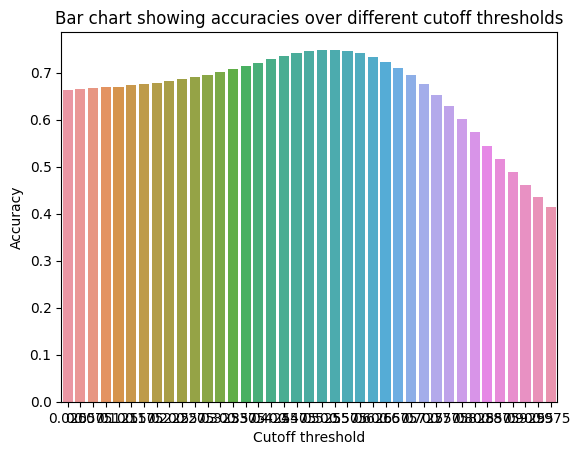

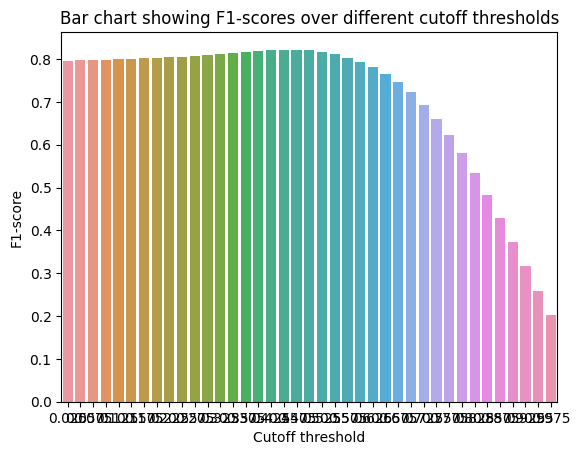

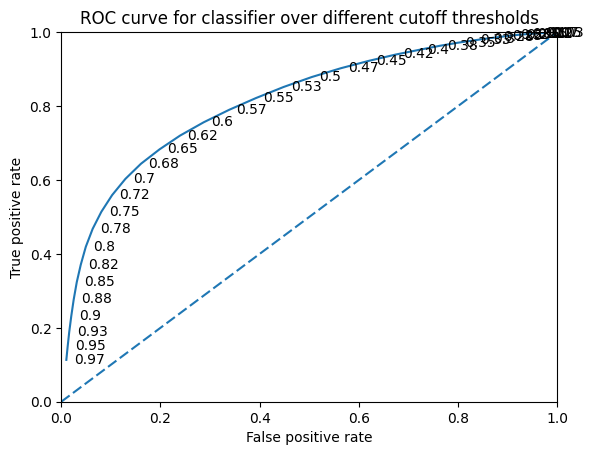

In [168]:
# Now we can evaluate the training
# ! We can actually also do some hyperparameter tuning (using ROC curves to determine the right cut-off probability) !

# Note ROC curves do not work well for linear regression, since there could be values that are not between 0 and 1!
# In this temporary example I just clip the predictions between 0 and 1

from metrics import confusion_matrix_statistics
import matplotlib.pyplot as plt
import seaborn as sns

num_values = 40
cutoff_values = [(i+1)/num_values for i in range(num_values-1)]

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (np.clip(X_train_public @ w_optim, a_min=0, a_max=1) > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_train_public)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)

plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % int(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

# Inference

In [ ]:
# Do predictions on the public test dataset


In [76]:
# Placeholder, array with True of False whether it belongs to the positive or negative sample
predictions = np.random.randint(2, size=ids_test_public.shape).astype(bool)

submission_file_name = 'submission_0.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], positive_sample if prediction else negative_sample])
